In [1]:
from get_datasets.Get_Datasets import get_data_array, get_datasets
from src.Evolutionary_Algorithm import create_next_population, create_first_population, select_best_2_model

import re
import os
import random
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [128, 128]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Label:  True


In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [10]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [11]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

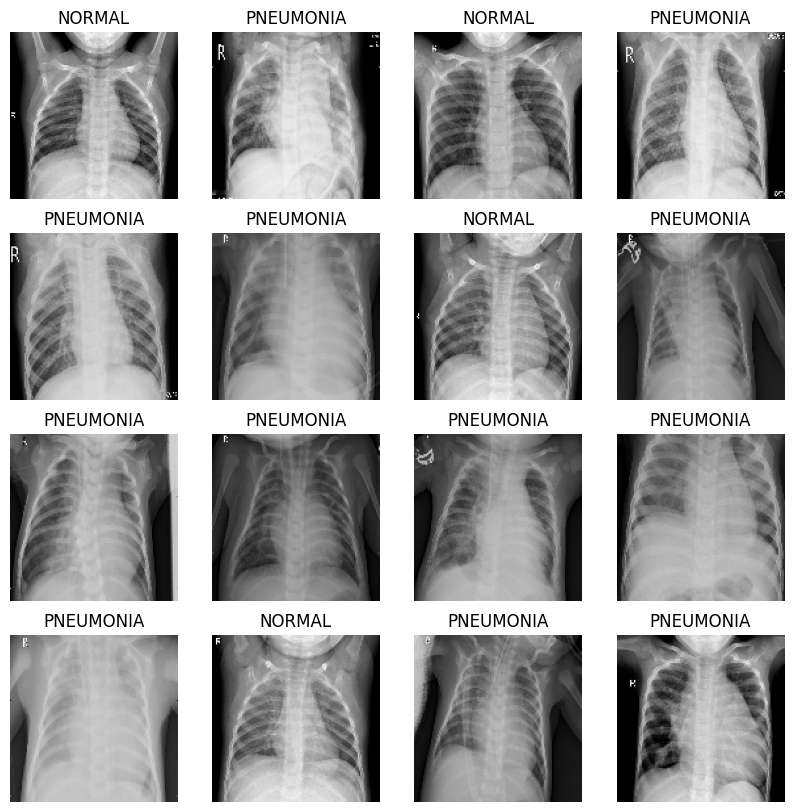

In [15]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
g1 = create_first_population(population=10)
p1, p2 = select_best_2_model(train_ds, val_ds ,test_ds, population_array=g1, epochs=20, num_classes=1)
g2 = create_next_population(parent_1_array=p1, parent_2_array=p2, population=10)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 16)   208         ['rescaling_1[0][0]']            
                                                                                                  
 batch_normalization_17 (BatchN  (None, 64, 64, 16)  64          ['conv2d_24[0][0]']        


KeyboardInterrupt

